In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pycorr 
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter


In [7]:
plt.style.use("astroandes.mplstyle")

In [8]:
def web_classification(n_data, n_random):
    assert len(n_data) == len(n_random)
    n_points = len(n_data)
    r_values = (n_data-n_random)/(n_data+n_random)
    web_class = np.zeros(n_points, dtype=int)
    lower_limit = -0.90
    upper_limit = 0.90
    is_void = r_values <= lower_limit
    is_sheet = (r_values > lower_limit) & (r_values<=0.0)
    is_filament = (r_values>0.0) & (r_values <= upper_limit)
    is_peak = (r_values > upper_limit)
    web_class[is_void] = 0
    web_class[is_sheet] = 1
    web_class[is_filament] = 2
    web_class[is_peak] = 3
    return web_class  

import numpy as np

def rotate_points_clockwise(X, Y, angle_degrees=135):
    """
    Rotate points (X, Y) clockwise around the origin by the specified angle.
    
    Parameters:
    -----------
    X, Y : numpy arrays or lists
        The x and y coordinates to rotate
    angle_degrees : float
        The angle in degrees to rotate clockwise
        
    Returns:
    --------
    X_rotated, Y_rotated : numpy arrays
        The rotated coordinates
    """
    # Convert angle to radians (positive for clockwise rotation)
    angle_radians = np.radians(angle_degrees)
    
    # Rotation matrix components
    cos_theta = np.cos(angle_radians)
    sin_theta = np.sin(angle_radians)
    
    # Apply rotation
    X_rotated = X * cos_theta + Y * sin_theta
    Y_rotated = -X * sin_theta + Y * cos_theta
    
    return X_rotated, Y_rotated

In [9]:
webs_data = {}
webs_random = {}
pos_data = {}
pos_random = {}

# TCW classification
tweb_data = np.loadtxt('../data/TCW/tcw_web/web_type_tweb.txt')
p_data = np.loadtxt('../data/TCW/pos/fof_catalog_200Mpc512_xyz.dat')
p_rand = np.loadtxt("../data/TCW/pos/random_000_fof_catalog_200Mpc512_xyz.dat")
hubble = 0.68
p_data = p_data[:,0:3]/hubble
p_rand = p_rand[:,0:3]/hubble
n_con_random = np.loadtxt("../data/TCW/web/random_000_fof_catalog_200Mpc512_xyz_fof_catalog_200Mpc512_xyz_nconnections.dat")
n_con_data = np.loadtxt("../data/TCW/web/fof_catalog_200Mpc512_xyz_random_000_fof_catalog_200Mpc512_xyz_nconnections.dat")
webs_data['TCW'] = web_classification(n_con_data[:,0], n_con_data[:,1])
webs_random['TCW'] = web_classification(n_con_random[:,0], n_con_random[:,1])
pos_data['TCW'] = p_data.copy()
pos_random['TCW'] = p_rand.copy()

# TNG classifications
p_data = np.loadtxt("../data/TNG/TNG300-1/pos/subhalo_massive_xyz.dat")
p_rand = np.loadtxt("../data/TNG/TNG300-1/pos/random_000_subhalo_massive_xyz.dat")
hubble=0.6774
p_data[:,0:3] = p_data[:,0:3]/1000.0/hubble
p_rand[:,0:3] = p_rand[:,0:3]/1000.0/hubble
n_con_random = np.loadtxt("../data/TNG/TNG300-1/web/random_000_subhalo_massive_xyz_subhalo_massive_xyz_nconnections.dat")
n_con_data = np.loadtxt("../data/TNG/TNG300-1/web/subhalo_massive_xyz_random_000_subhalo_massive_xyz_nconnections.dat")
webs_data['TNG'] = web_classification(n_con_data[:,0], n_con_data[:,1])
webs_random['TNG'] = web_classification(n_con_random[:,0], n_con_random[:,1])
pos_data['TNG'] = p_data.copy()
pos_random['TNG'] = p_rand.copy()

#SDSS classification
p_data = np.loadtxt("../data/SDSS/pos/mag_r_limited_xyz.dat")
p_rand = np.loadtxt("../data/SDSS/pos/random_000_mag_r_limited_xyz.dat")
p_data = p_data[:,0:3]
p_rand = p_rand[:,0:3]
p_data[:,0], p_data[:,1] = rotate_points_clockwise(p_data[:,0], p_data[:,1])
p_rand[:,0], p_rand[:,1] = rotate_points_clockwise(p_rand[:,0], p_rand[:,1])

n_con_random = np.loadtxt("../data/SDSS/web/random_000_mag_r_limited_xyz_mag_r_limited_xyz_nconnections.dat")
n_con_data = np.loadtxt("../data/SDSS/web/mag_r_limited_xyz_random_000_mag_r_limited_xyz_nconnections.dat")

webs_data['SDSS'] = web_classification(n_con_data[:,0], n_con_data[:,1])
webs_random['SDSS'] = web_classification(n_con_random[:,0], n_con_random[:,1])
pos_data['SDSS'] = p_data.copy()
pos_random['SDSS'] = p_rand.copy()

In [10]:
def compute_classification_statistics(dataset_name, pos_data_dict, webs_data_dict, num_files=100):
    """
    Compute classification statistics by reading multiple random files.
    
    Parameters:
    -----------
    dataset_name : str
        Name of the dataset ('TCW', 'SDSS', or 'TNG')
    pos_data_dict : dict
        Dictionary containing position data for all datasets
    webs_data_dict : dict
        Dictionary containing web classification data for all datasets
    num_files : int
        Number of random files to process (default: 100)
        
    Returns:
    --------
    classification_counts : dict
        Dictionary containing counts for each classification type for each point
    """
    # Initialize dictionary to store classification counts
    classification_counts = {
        'void': np.zeros(len(pos_data_dict[dataset_name])),
        'sheet': np.zeros(len(pos_data_dict[dataset_name])),
        'filament': np.zeros(len(pos_data_dict[dataset_name])),
        'peak': np.zeros(len(pos_data_dict[dataset_name]))
    }
    
    # Process the first classification we already have
    for i, cls in enumerate(webs_data_dict[dataset_name]):
        if cls == 0:
            classification_counts['void'][i] += 1
        elif cls == 1:
            classification_counts['sheet'][i] += 1
        elif cls == 2:
            classification_counts['filament'][i] += 1
        elif cls == 3:
            classification_counts['peak'][i] += 1
    
    # Process additional random files (starting from 001 since 000 is already loaded)
    for random_idx in range(1, num_files):
        # Construct filename with proper padding
        random_str = f"{random_idx:03d}"
        
        try:
            # Load data according to dataset
            if dataset_name == 'TCW':
                n_con_random = np.loadtxt(f"../data/TCW/web/random_{random_str}_fof_catalog_200Mpc512_xyz_fof_catalog_200Mpc512_xyz_nconnections.dat")
                n_con_data = np.loadtxt(f"../data/TCW/web/fof_catalog_200Mpc512_xyz_random_{random_str}_fof_catalog_200Mpc512_xyz_nconnections.dat")
            elif dataset_name == 'TNG':
                n_con_random = np.loadtxt(f"../data/TNG/TNG300-1/web/random_{random_str}_subhalo_massive_xyz_subhalo_massive_xyz_nconnections.dat")
                n_con_data = np.loadtxt(f"../data/TNG/TNG300-1/web/subhalo_massive_xyz_random_{random_str}_subhalo_massive_xyz_nconnections.dat")
            elif dataset_name == 'SDSS':
                n_con_random = np.loadtxt(f"../data/SDSS/web/random_{random_str}_mag_r_limited_xyz_mag_r_limited_xyz_nconnections.dat")
                n_con_data = np.loadtxt(f"../data/SDSS/web/mag_r_limited_xyz_random_{random_str}_mag_r_limited_xyz_nconnections.dat")
            
            # Calculate classifications
            classifications = web_classification(n_con_data[:,0], n_con_data[:,1])
            
            # Update counts
            for i, cls in enumerate(classifications):
                if cls == 0:
                    classification_counts['void'][i] += 1
                elif cls == 1:
                    classification_counts['sheet'][i] += 1
                elif cls == 2:
                    classification_counts['filament'][i] += 1
                elif cls == 3:
                    classification_counts['peak'][i] += 1
                    
        except FileNotFoundError as e:
            print(f"Warning: File not found for {dataset_name}, random_{random_str}. Skipping.")
            continue
    
    return classification_counts

# Process all datasets
all_classification_stats = {}
for dataset in ['TCW', 'SDSS', 'TNG']:
    print(f"Processing {dataset} dataset...")
    all_classification_stats[dataset] = compute_classification_statistics(
        dataset, 
        pos_data,  # Pass the global pos_data dictionary
        webs_data, # Pass the global webs_data dictionary
        num_files=100
    )
    
print("Done!")

Processing TCW dataset...
Processing SDSS dataset...
Processing TNG dataset...
Done!


In [11]:
all_classification_stats['TCW']

{'void': array([0., 0., 0., ..., 0., 0., 0.]),
 'sheet': array([  0.,   0.,   0., ...,   0.,   0., 100.]),
 'filament': array([37., 26., 35., ..., 95., 93.,  0.]),
 'peak': array([63., 74., 65., ...,  5.,  7.,  0.])}

In [23]:
def calculate_classification_entropy(classification_counts, num_files=100):
    """
    Calculate Shannon entropy for classification probabilities of each point.
    
    Parameters:
    -----------
    classification_counts : dict
        Dictionary containing counts for each classification type
    num_files : int
        Total number of classifications per point (default: 100)
        
    Returns:
    --------
    entropy : numpy array
        Shannon entropy for each point
    probabilities : dict
        Dictionary containing probabilities for each classification type
    """
    # Calculate probabilities by dividing counts by total files
    probabilities = {
        'void': classification_counts['void'] / num_files,
        'sheet': classification_counts['sheet'] / num_files,
        'filament': classification_counts['filament'] / num_files,
        'peak': classification_counts['peak'] / num_files
    }
    
    # Calculate Shannon entropy: -sum(p_i * log2(p_i))
    entropy = np.zeros(len(probabilities['void']))
    
    for env_type in ['void', 'sheet', 'filament', 'peak']:
        # Get probabilities for this environment type
        p = probabilities[env_type]
        
        # Avoid log(0) by masking zero probabilities
        mask = p > 0
        
        # Add -p*log2(p) to entropy where p > 0
        entropy[mask] -= p[mask] * np.log2(p[mask])

    # Add proper normalization
    entropy = entropy/np.log2(4)
    
    return entropy, probabilities

# Process all datasets to calculate entropy and probabilities
for dataset in all_classification_stats:
    print(f"Calculating entropy for {dataset} dataset...")
    entropy, probabilities = calculate_classification_entropy(all_classification_stats[dataset])
    
    # Store results in the main dictionary
    all_classification_stats[dataset]['entropy'] = entropy
    all_classification_stats[dataset]['probabilities'] = probabilities

print("Done!")

Calculating entropy for TCW dataset...
Calculating entropy for SDSS dataset...
Calculating entropy for TNG dataset...
Done!


In [70]:
def plot_entropy_distribution(entropy_dict, bins=16, figsize=(6, 4)):
    """
    Plot histogram of entropy values for different datasets.
    
    Parameters:
    -----------
    entropy_dict : dict
        Dictionary with dataset names as keys and entropy arrays as values
    bins : int
        Number of bins for the histogram
    figsize : tuple
        Figure size (width, height)
        
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    linestyles = ['-', '--', '-.']
    
    for i, (dataset, entropy_values) in enumerate(entropy_dict.items()):
        # Calculate histogram - entropy range from 0 to 2
        hist, bin_edges = np.histogram(entropy_values, bins=bins, range=(0, 0.6), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Plot histogram as line
        ax.plot(bin_centers, hist, label=dataset, color=colors[i % len(colors)],
                linestyle=linestyles[i % len(linestyles)], linewidth=2)
    
    # Set plot properties
    ax.set_xlabel(r"Normalized Shannon Entropy", fontsize=20)
    ax.set_ylabel("PDF", fontsize=20)
    ax.legend(fontsize=20, loc=1)
    ax.set_xlim(0, 0.6)
    plt.xlim([0, 0.6])
    plt.ylim([0, 5.5])
    
    # Format y-axis to remove scientific notation
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
    plt.tight_layout()
    plt.savefig('entropy_distribution.pdf', dpi=300)
    
    return fig, ax

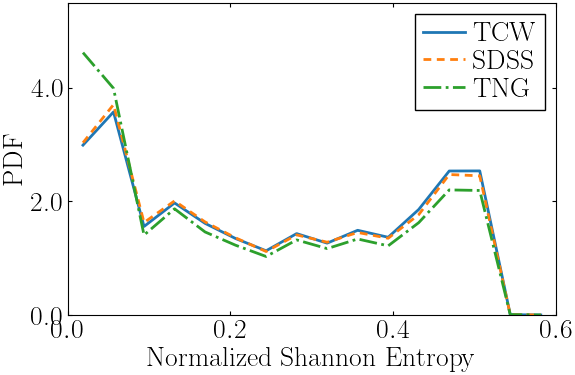

In [71]:
entropy_dict = {
    'TCW': all_classification_stats['TCW']['entropy'],
    'SDSS': all_classification_stats['SDSS']['entropy'],
    'TNG': all_classification_stats['TNG']['entropy']
}

entropy_fig, entropy_ax = plot_entropy_distribution(entropy_dict)

In [65]:
def analyze_entropy_statistics(entropy_dict):
    """
    Calculate statistics about entropy values for different datasets.
    
    Parameters:
    -----------
    entropy_dict : dict
        Dictionary with dataset names as keys and entropy arrays as values
        
    Returns:
    --------
    stats : dict
        Dictionary with entropy statistics for each dataset
    """
    stats = {}
    
    for dataset, entropy_values in entropy_dict.items():
        # Count points with entropy > 0.5
        high_entropy_count = np.sum(entropy_values > 0.5)
        total_points = len(entropy_values)
        high_entropy_fraction = high_entropy_count / total_points * 100
        
        # Find maximum entropy value
        max_entropy = np.max(entropy_values)
        
        # Store statistics
        stats[dataset] = {
            'high_entropy_count': high_entropy_count,
            'total_points': total_points,
            'high_entropy_fraction': high_entropy_fraction,
            'max_entropy': max_entropy
        }
    
    return stats

# Create entropy dictionary if not already done
entropy_dict = {
    'TCW': all_classification_stats['TCW']['entropy'],
    'SDSS': all_classification_stats['SDSS']['entropy'],
    'TNG': all_classification_stats['TNG']['entropy']
}

# Calculate and print entropy statistics
entropy_stats = analyze_entropy_statistics(entropy_dict)

# Print results in a formatted table
print("\nEntropy Statistics:")
print("=" * 60)
print(f"{'Dataset':<10} {'Points with Entropy > 0.5':<25} {'Percentage (%)':<15} {'Max Entropy':<15}")
print("-" * 60)

for dataset, stats in entropy_stats.items():
    print(f"{dataset:<10} {stats['high_entropy_count']:<25,d} {stats['high_entropy_fraction']:<15.2f} {stats['max_entropy']:<15.4f}")

print("=" * 60)


Entropy Statistics:
Dataset    Points with Entropy > 0.5 Percentage (%)  Max Entropy    
------------------------------------------------------------
TCW        140                       0.05            0.5584         
SDSS       46                        0.05            0.5459         
TNG        97                        0.04            0.5661         


In [ ]:
def compute_r_values(n_data, n_random):
    """
    Compute the r parameter used for cosmic web classification.
    
    Parameters:
    -----------
    n_data : numpy array
        Number of connections to data points
    n_random : numpy array
        Number of connections to random points
        
    Returns:
    --------
    r_values : numpy array
        The computed r values: (n_data - n_random) / (n_data + n_random)
    """
    return (n_data - n_random) / (n_data + n_random)
    
def compute_r_statistics(dataset_names, num_files=100):
    """
    Compute mean and standard deviation of r values for each dataset.
    
    Parameters:
    -----------
    dataset_names : list
        List of dataset names to process
    num_files : int
        Number of random files used
        
    Returns:
    --------
    mean_r_dict : dict
        Dictionary containing mean r values for each dataset
    std_r_dict : dict
        Dictionary containing standard deviations of r values for each dataset
    """
    mean_r_dict = {}
    std_r_dict = {}
    
    for dataset in dataset_names:
        print(f"Processing {dataset} dataset...")
        
        # Initialize list to store individual r values
        r_values_all = []
        
        # Process the first file we already have
        if dataset == 'TCW':
            n_con_data = np.loadtxt("../data/TCW/web/fof_catalog_200Mpc512_xyz_random_000_fof_catalog_200Mpc512_xyz_nconnections.dat")
        elif dataset == 'TNG':
            n_con_data = np.loadtxt("../data/TNG/TNG300-1/web/subhalo_massive_xyz_random_000_subhalo_massive_xyz_nconnections.dat")
        elif dataset == 'SDSS':
            n_con_data = np.loadtxt("../data/SDSS/web/mag_r_limited_xyz_random_000_mag_r_limited_xyz_nconnections.dat")
        
        # Calculate r values for first file
        r_values = compute_r_values(n_con_data[:, 0], n_con_data[:, 1])
        r_values_all.append(r_values)
        
        # Process additional random files
        for random_idx in range(1, num_files):
            # Construct filename with proper padding
            random_str = f"{random_idx:03d}"
            
            try:
                # Load data according to dataset
                if dataset == 'TCW':
                    n_con_data = np.loadtxt(f"../data/TCW/web/fof_catalog_200Mpc512_xyz_random_{random_str}_fof_catalog_200Mpc512_xyz_nconnections.dat")
                elif dataset == 'TNG':
                    n_con_data = np.loadtxt(f"../data/TNG/TNG300-1/web/subhalo_massive_xyz_random_{random_str}_subhalo_massive_xyz_nconnections.dat")
                elif dataset == 'SDSS':
                    n_con_data = np.loadtxt(f"../data/SDSS/web/mag_r_limited_xyz_random_{random_str}_mag_r_limited_xyz_nconnections.dat")
                
                # Calculate r values for this file
                r_values = compute_r_values(n_con_data[:, 0], n_con_data[:, 1])
                r_values_all.append(r_values)
                
            except FileNotFoundError:
                print(f"Warning: File not found for {dataset}, random_{random_str}. Skipping.")
                continue
        
        # Convert list of arrays to 2D array (each row is a different random realization)
        r_values_all = np.array(r_values_all)
        
        # Calculate mean and std of r values across all random realizations
        mean_r_dict[dataset] = np.mean(r_values_all, axis=0)
        std_r_dict[dataset] = np.std(r_values_all, axis=0)
        
        print(f"Completed {dataset} dataset. Processed {len(r_values_all)} random files.")
    
    return mean_r_dict, std_r_dict

In [85]:
def plot_r_std_vs_r_mean(mean_r_dict, std_r_dict, figsize=(12, 4)):
    """
    Plot the standard deviation of r values as a function of mean r for each dataset.
    
    Parameters:
    -----------
    mean_r_dict : dict
        Dictionary containing mean r values for each dataset
    std_r_dict : dict
        Dictionary containing standard deviations of r values for each dataset
    figsize : tuple
        Figure size (width, height)
        
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    # Get dataset names from the dictionaries
    dataset_names = list(mean_r_dict.keys())
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(dataset_names), figsize=figsize)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, dataset in enumerate(dataset_names):
        r_mean = mean_r_dict[dataset]
        r_std = std_r_dict[dataset]
        
        # Create scatter plot
        scatter = axes[i].scatter(r_mean, r_std, s=1, alpha=0.1, color=colors[i])
        
        # Add binned average line with 20 bins
        bin_edges = np.linspace(-1, 1, 21)  # 20 bins from -1 to 1
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        binned_std = np.zeros_like(bin_centers)
        
        # Arrays to store 1-sigma percentiles for each bin
        lower_percentile = np.zeros_like(bin_centers)
        upper_percentile = np.zeros_like(bin_centers)
        
        for j in range(len(bin_centers)):
            mask = (r_mean >= bin_edges[j]) & (r_mean < bin_edges[j+1])
            if np.sum(mask) > 0:
                binned_std[j] = np.mean(r_std[mask])
                
                # Calculate 1-sigma percentiles (16th and 84th percentiles)
                lower_percentile[j] = np.percentile(r_std[mask], 16)
                upper_percentile[j] = np.percentile(r_std[mask], 84)
        
        # Plot binned average line
        axes[i].plot(bin_centers, binned_std, color='red', linewidth=2, label='Mean')
        
        # Plot 1-sigma percentile lines
        axes[i].plot(bin_centers, lower_percentile, color='red', linestyle=':', linewidth=1.5, label='16th percentile')
        axes[i].plot(bin_centers, upper_percentile, color='red', linestyle=':', linewidth=1.5, label='84th percentile')
        
        # Set plot properties
        axes[i].set_title(dataset, fontsize=14)
        axes[i].set_xlabel(r"Mean $r$", fontsize=12)
        if i == 0:
            axes[i].set_ylabel(r"Standard Deviation of $r$", fontsize=12)
        axes[i].set_xlim(-1, 1)
        axes[i].set_ylim(0, 0.3)  # Start y-axis at 0
        axes[i].grid(True, alpha=0.3)
        
        # Add vertical lines for classification thresholds
        lower_limit = -0.90
        upper_limit = 0.90
        mid_point = 0.0
        
        axes[i].axvline(x=lower_limit, color='gray', linestyle=':', alpha=0.7)
        axes[i].axvline(x=mid_point, color='gray', linestyle=':', alpha=0.7)
        axes[i].axvline(x=upper_limit, color='gray', linestyle=':', alpha=0.7)
        
        # Add legend only to the first plot to avoid redundancy
        if i == 0:
            axes[i].legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('r_std_vs_r_mean.pdf', dpi=300, bbox_inches='tight')
    
    return fig, axes

In [81]:
# Step 1: Compute r-value statistics for all datasets
mean_r_dict, std_r_dict = compute_r_statistics(['TCW', 'SDSS', 'TNG'])

Processing TCW dataset...
Completed TCW dataset. Processed 100 random files.
Processing SDSS dataset...
Completed SDSS dataset. Processed 100 random files.
Processing TNG dataset...
Completed TNG dataset. Processed 100 random files.


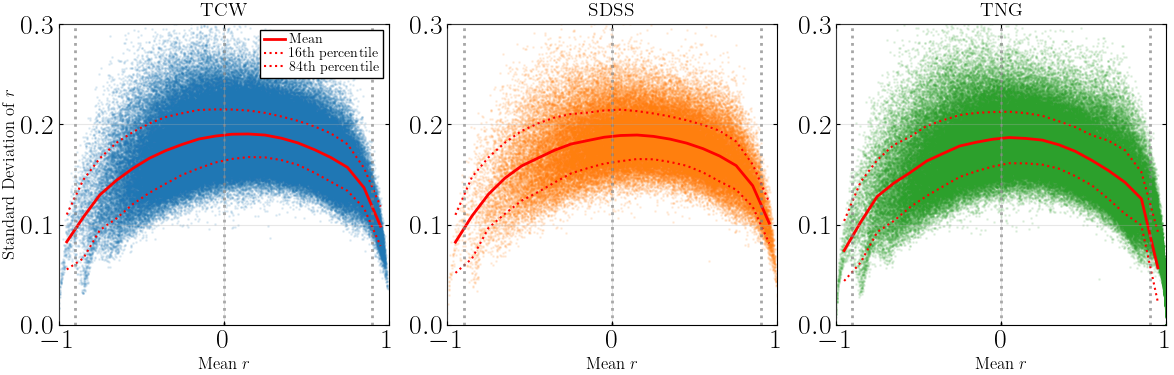

In [86]:
# Step 2: Create the plots using the computed statistics
fig, axes = plot_r_std_vs_r_mean(mean_r_dict, std_r_dict)

In [93]:
def plot_r_cumulative_distribution(mean_r_dict, figsize=(5, 4)):
    """
    Create a cumulative distribution plot of the average r-values for all datasets.
    
    Parameters:
    -----------
    mean_r_dict : dict
        Dictionary containing mean r values for each dataset
    figsize : tuple
        Figure size (width, height)
        
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    linestyles = ['-', '--', '-.']
    
    # Get dataset names
    dataset_names = list(mean_r_dict.keys())
    
    # Plot cumulative distribution for each dataset
    for i, dataset in enumerate(dataset_names):
        r_mean = mean_r_dict[dataset]
        
        # Sort the data for CDF
        r_sorted = np.sort(r_mean)
        
        # Calculate cumulative probabilities
        y_values = np.arange(1, len(r_sorted) + 1) / len(r_sorted)
        
        # Plot CDF
        ax.plot(r_sorted, y_values, label=dataset, 
                color=colors[i % len(colors)],
                linestyle=linestyles[i % len(linestyles)],
                linewidth=2)
    
    # Add vertical lines for classification thresholds
    lower_limit = -0.90
    upper_limit = 0.90
    mid_point = 0.0
    
    ax.axvline(x=lower_limit, color='gray', linestyle=':', alpha=0.7)
    ax.axvline(x=mid_point, color='gray', linestyle=':', alpha=0.7)
    ax.axvline(x=upper_limit, color='gray', linestyle=':', alpha=0.7)
    
    # Add text labels for cosmic web types
    ylim = ax.get_ylim()
    text_y = ylim[1] * 0.95
    ax.text((lower_limit - 1) / 2, text_y, "VOIDS", ha='center', fontsize=10)
    ax.text((mid_point + lower_limit) / 2, text_y, "SHEETS", ha='center', fontsize=10)
    ax.text((upper_limit + mid_point) / 2, text_y, "FILAMENTS", ha='center', fontsize=10)
    ax.text((1 + upper_limit) / 2, text_y, "KNOTS", ha='center', fontsize=10)
    
    # Set plot properties
    ax.set_xlabel(r"Average $r$ value", fontsize=14)
    ax.set_ylabel("Cumulative Probability", fontsize=14)
    #ax.set_title("Cumulative Distribution of Average r-values", fontsize=16)
    ax.legend(fontsize=20)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('r_cumulative_distribution.pdf', dpi=300, bbox_inches='tight')
    
    return fig, ax

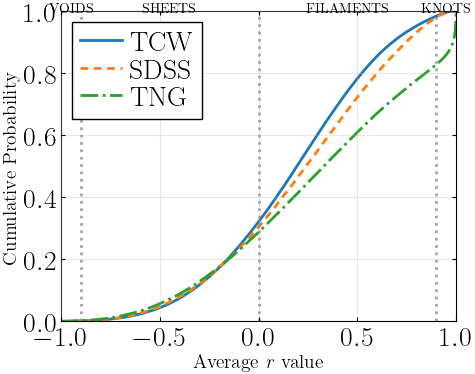

In [94]:
# Create cumulative distribution plot
fig, ax = plot_r_cumulative_distribution(mean_r_dict)